In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import pandas as pd

from TCGAMultiOmics.multiomics import MultiOmicsData
from moge.network.heterogeneous_network import HeterogeneousNetwork

from moge.visualization.plot_data import matrix_heatmap

#  Import network from file

In [2]:
import pickle

# READ
with open('moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/LMN_mirtarbase_biogrid_starbase_lncrna2target_lncrinter.train.pickle', 'rb') as file:
    network = pickle.load(file)
#     network.process_genes_info()

# READ Edgeslist
# network.import_edgelist_file(
#     file="moge/data/LMN_only_directed/lmn_l08_m08_l08__correlation_node_similarity.edgelist", 
#                              is_directed=True)

In [3]:
# READ edgelists
with open('moge/data/LMN_future_recall/TEST/Interactions_Affinity/LMN_mirtarbase_biogrid_starbase_lncrna2target_lncrinter.test.pickle', 'rb') as file:
    network_val = pickle.load(file)
#     network_val.process_genes_info()

# print("network_test", network_test.G.number_of_edges())
# print("network_val", network_val.G.number_of_edges())

In [4]:
import pickle
with open('moge/data/luad_data_shortest.pickle', 'rb') as file:
    luad_data = pickle.load(file)
    network.multi_omics_data = luad_data
    network_val.multi_omics_data = luad_data
    network.process_genes_info()
    network_val.process_genes_info()

Genes info columns: ['Disease association', 'locus_type', 'Transcript sequence', 'GO Terms', 'Family']
Number of nodes without seq removed: -44
Total nodes (filtered): 32697
Genes info columns: ['Disease association', 'locus_type', 'Transcript sequence', 'GO Terms', 'Family']
Number of nodes without seq removed: -21066
Total nodes (filtered): 11675


In [5]:
network.G.remove_edges_from([(u,v,d) for u,v,d in network.G.edges(data=True) if d["type"]=="u" or d["type"]=="u_n"])

# Data Visualization

KeyboardInterrupt: 

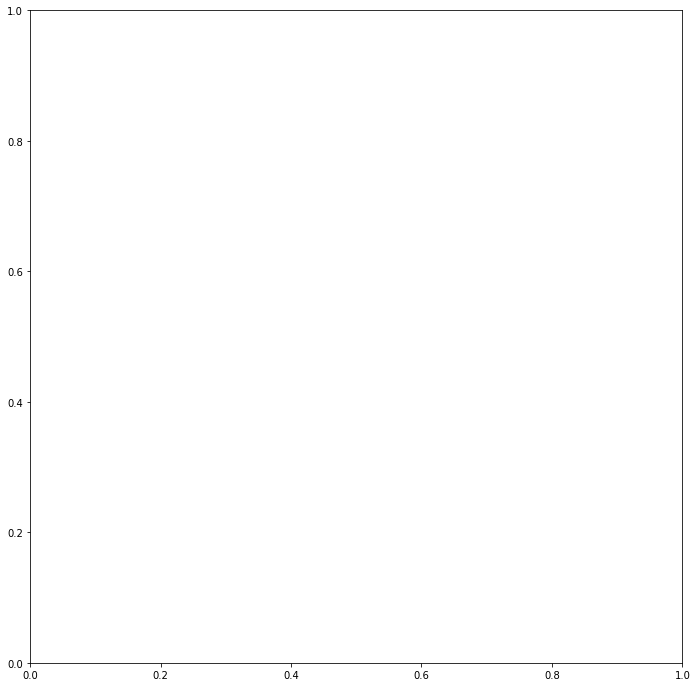

In [4]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["d"], node_list=network.node_list).todense())

In [ ]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.node_list).todense())

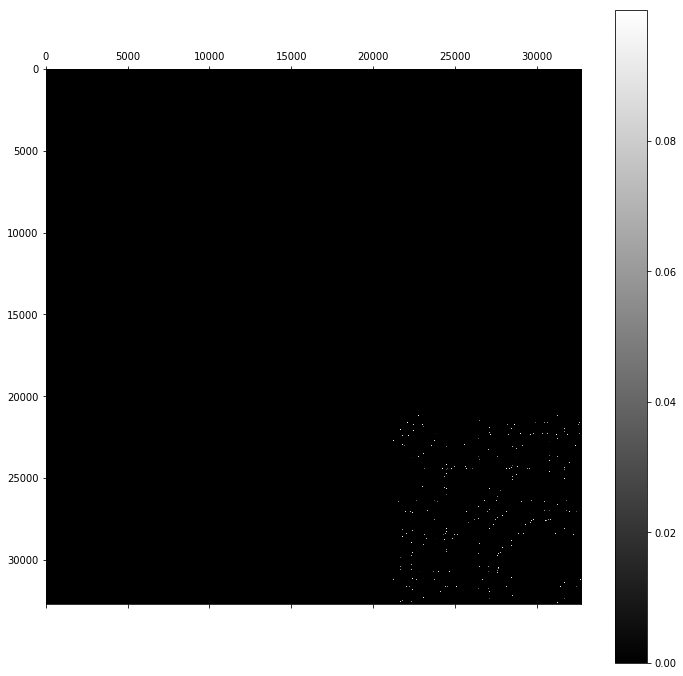

In [ ]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u_n"], node_list=network.node_list).todense())

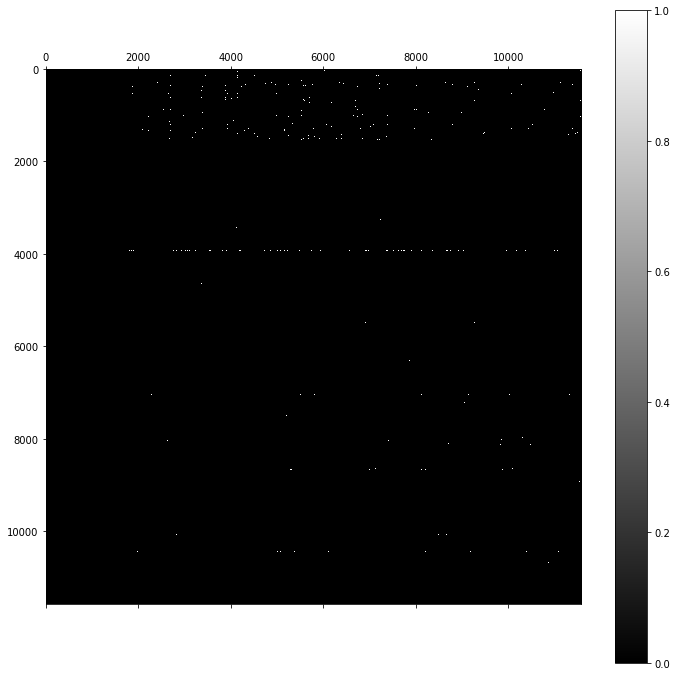

In [5]:
# The test data to recall
matrix_heatmap(network_val.get_adjacency_matrix(edge_types=["d"], node_list=network_val.node_list).todense())

# Train

In [ ]:
from moge.embedding.siamese_graph_embedding import SiameseGraphEmbedding, SiameseTripletGraphEmbedding

# siamese = SiameseGraphEmbedding(d=128, batch_size=1024, lr=0.001, epochs=50, negative_sampling_ratio=2.0,
#                                  max_length=2000, truncating="post", verbose=True)

siamese = SiameseTripletGraphEmbedding(d=128, batch_size=384, margin=0.2, lr=0.001, epochs=50, negative_sampling_ratio=2.0,
                                 max_length=2000, truncating="post", verbose=True)

Using TensorFlow backend.


In [ ]:
siamese.learn_embedding(network, network_val=network_val, multi_gpu=False, 
    subsample=True, directed_proba=0.8, n_steps=1000, validation_steps=None, 
    compression_func="sqrt",
    validation_make_data=True,
    seed=3)

Using SampledTripletDataGenerator
Using SampledDataGenerator
Ed_count: 596408 , Eu_count: 151513 , En_count: 755561


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/data_generator.py:62: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  self.process_negative_sampling_edges()


Ens_count: 1192816
word index: {'A': 1, 'T': 2, 'G': 3, 'C': 4}
# of nodes to sample from (non-zero degree): 28597
Using SampledTripletDataGenerator
Using SampledDataGenerator
Ed_count: 88283 , Eu_count: 0 , En_count: 0
Ens_count: 88283
word index: {'A': 1, 'T': 2, 'G': 3, 'C': 4}
# of nodes to sample from (non-zero degree): 3782
Embedding Tensor("embedding_1/embedding_lookup/Identity:0", shape=(?, ?, 4), dtype=float32, device=/device:GPU:0)
conv2D Tensor("lstm_lambda_2/Squeeze:0", shape=(?, ?, 192), dtype=float32, device=/device:GPU:0)
max pooling_1 Tensor("max_pooling1d_1/Squeeze:0", shape=(?, ?, 192), dtype=float32, device=/device:GPU:0)
conv1d_2 Tensor("conv1d_1/Relu:0", shape=(?, ?, 320), dtype=float32, device=/device:GPU:0)
max pooling_2 Tensor("max_pooling1d_2/Squeeze:0", shape=(?, ?, 320), dtype=float32, device=/device:GPU:0)
brnn Tensor("bidirectional_1/concat_2:0", shape=(?, 640), dtype=float32, device=/device:GPU:0)
embedding Tensor("embedding_output/BiasAdd:0", shape=(?, 12

# Visualize Embeddings

In [ ]:
matrix_heatmap(siamese.get_embedding(recompute=True), cmap="bwr", aspect='auto', figsize=(7,10))

In [ ]:
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="d", node_l=network.node_list), figsize=(7,7))

In [ ]:
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="u"), figsize=(7,7))

# Save Model & Embedding

In [ ]:
siamese.lstm_network.save("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lstm_128.randtrunc.multi_seq_UT.biogrid.full.euclidean.e50.model.h5")
# siamese.alpha_network.save_weights("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/alpha_128.randtrunc.multi_seq.no_starbase.sampled.l1_bce.e20.weights.h5")

In [101]:
siamese.truncating = "post"
siamese.save_embeddings("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lmn_train.siamese.multi_seq_UT.biogrid.full.euclidean.trunc.emb", 
                        variable_length=False, recompute=False, minlen=100)

# Import different models

In [9]:
from moge.embedding.static_graph_embedding import ImportedGraphEmbedding

node2vec_emb = ImportedGraphEmbedding(d=128, method_name="node2vec")
node2vec_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.node2vec.emb", 
                          node_list=network.node_list)

line_emb = ImportedGraphEmbedding(d=128, method_name="LINE")
line_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.line.emb", 
                          node_list=network.node_list)

hope_emb = ImportedGraphEmbedding(d=128, method_name="HOPE")
hope_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.hope.emb", 
                          node_list=network.node_list)

sdne_emb = ImportedGraphEmbedding(d=128, method_name="SDNE")
sdne_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.sdne.emb", 
                          node_list=network.node_list)


rna2rna_emb = ImportedGraphEmbedding(d=128, method_name="rna2rna")
rna2rna_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lmn_train.siamese.multi_seq_UT.biogrid.full.euclidean.trunc.emb", 
                         node_list=network.node_list)
print()

node2vec imported (20447, 128)
LINE imported (20447, 128)
HOPE imported (20447, 128)
SDNE imported (20447, 128)
rna2rna imported (32663, 128)



In [10]:
methods = {}
methods["node2vec"] = node2vec_emb
methods["LINE"] = line_emb
methods["HOPE"] = hope_emb
methods["SDNE"] = sdne_emb
methods["rna2rna"] = rna2rna_emb
methods["siamese"] = siamese

# Prepare True label

In [11]:
from moge.network.data_generator import DataGenerator

negative_sampling_ratio = 2.0
generator_Ed = DataGenerator(network=network_val, 
                             negative_sampling_ratio=negative_sampling_ratio,
                             batch_size=1,
                             maxlen=siamese.max_length,
                             truncating="post",
                             shuffle=True, seed=1)
generator_Ed.on_epoch_end()


Ed_count: 88283 , Eu_count: 0 , En_count: 0
Ens_count: 176566
word index: {'A': 1, 'T': 2, 'G': 3, 'C': 4}


# Plot Precision-Recall Curve

lncrna2target
Ed_count: 564 , Eu_count: 0 , En_count: 0


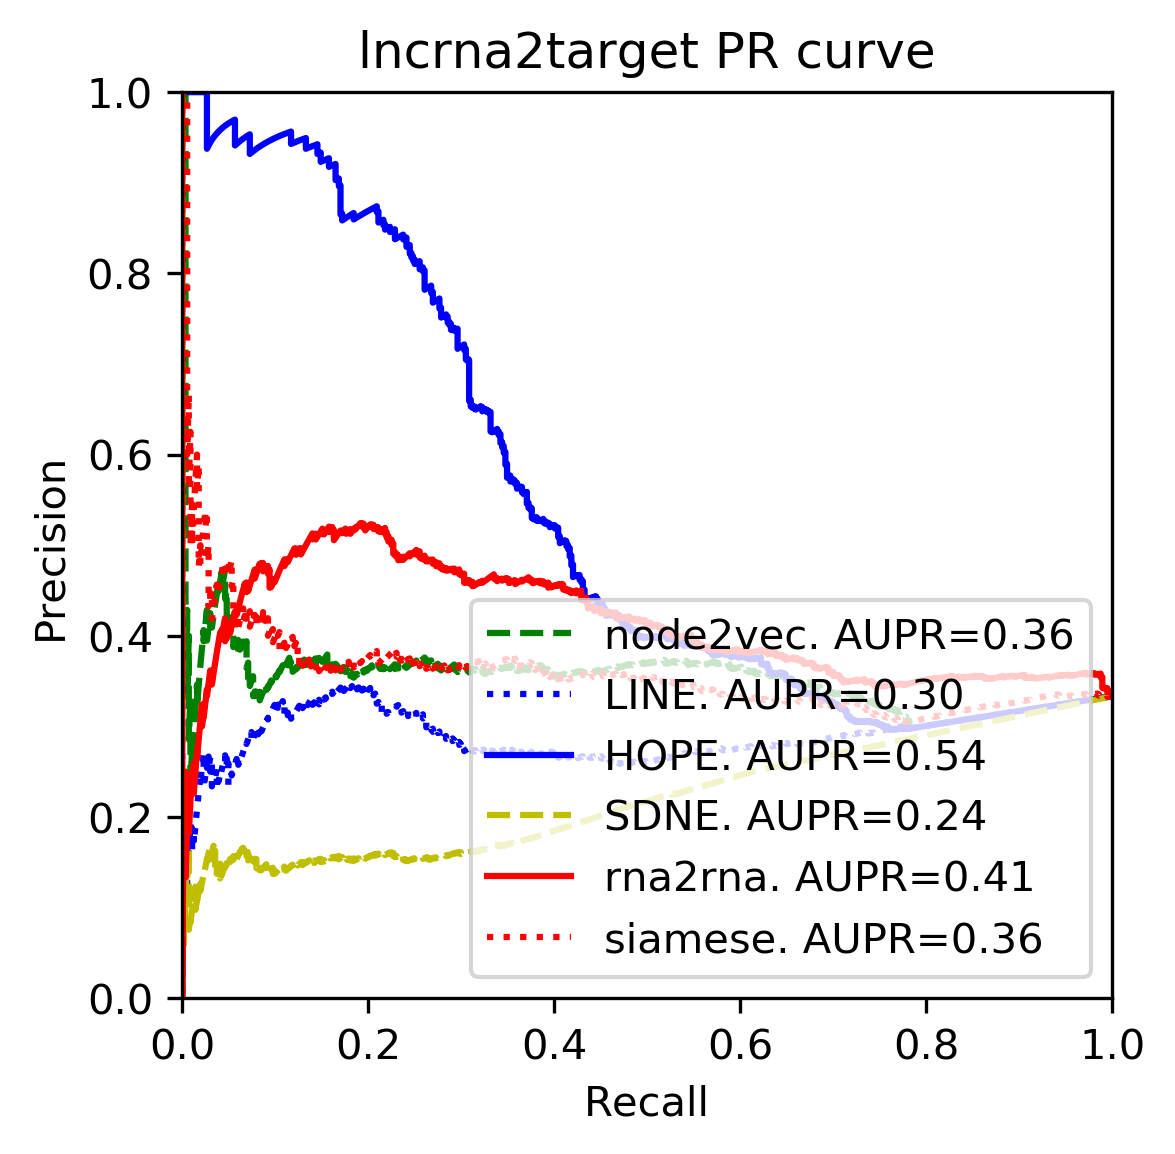

miRTarBase
Ed_count: 55895 , Eu_count: 0 , En_count: 0


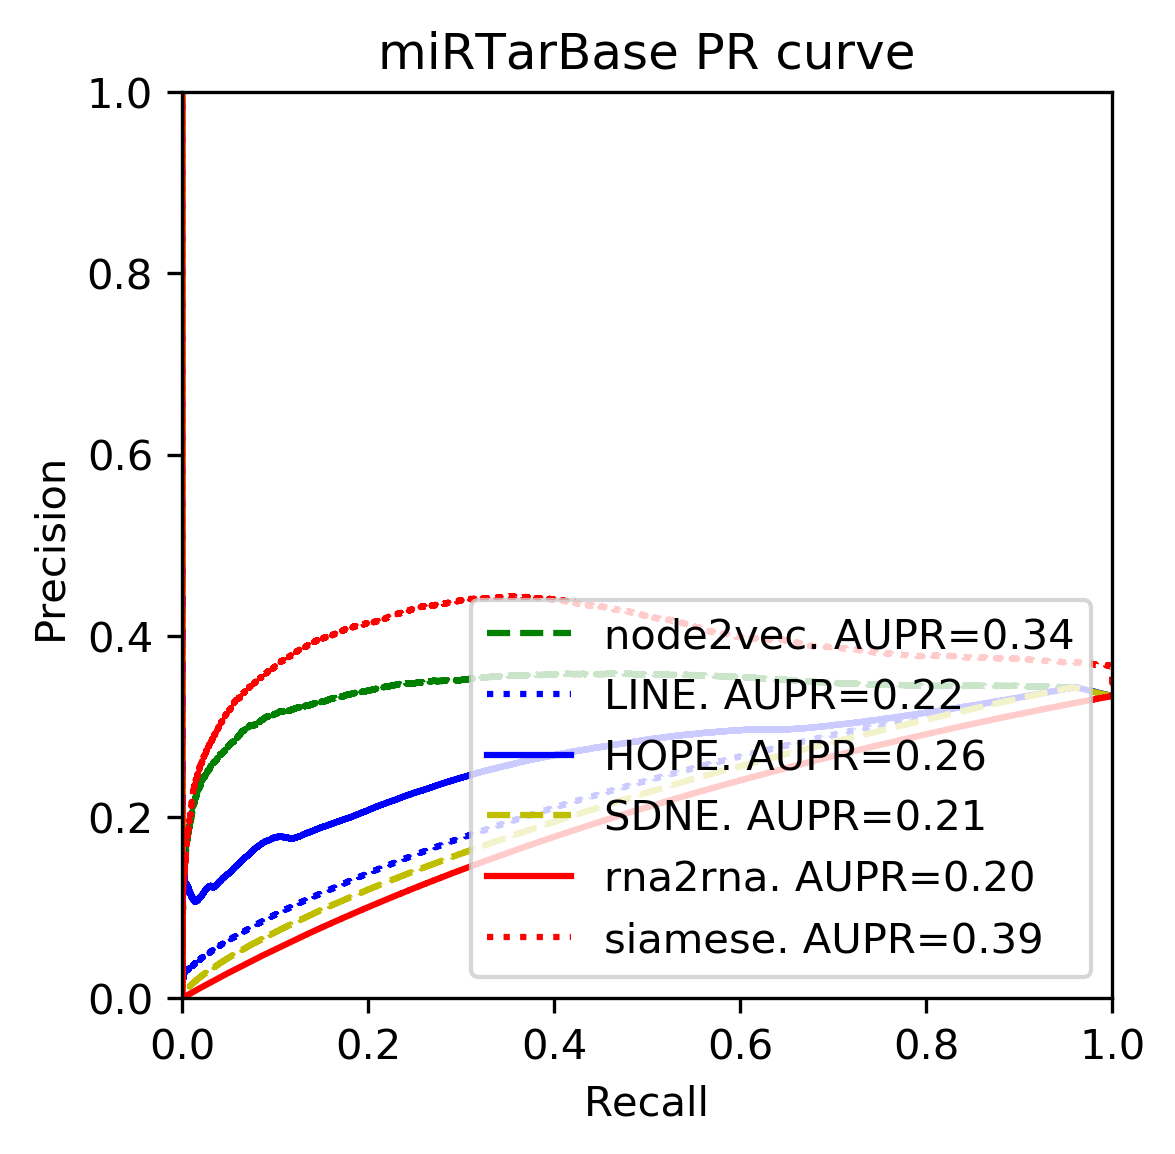

BioGRID
Ed_count: 31633 , Eu_count: 0 , En_count: 0


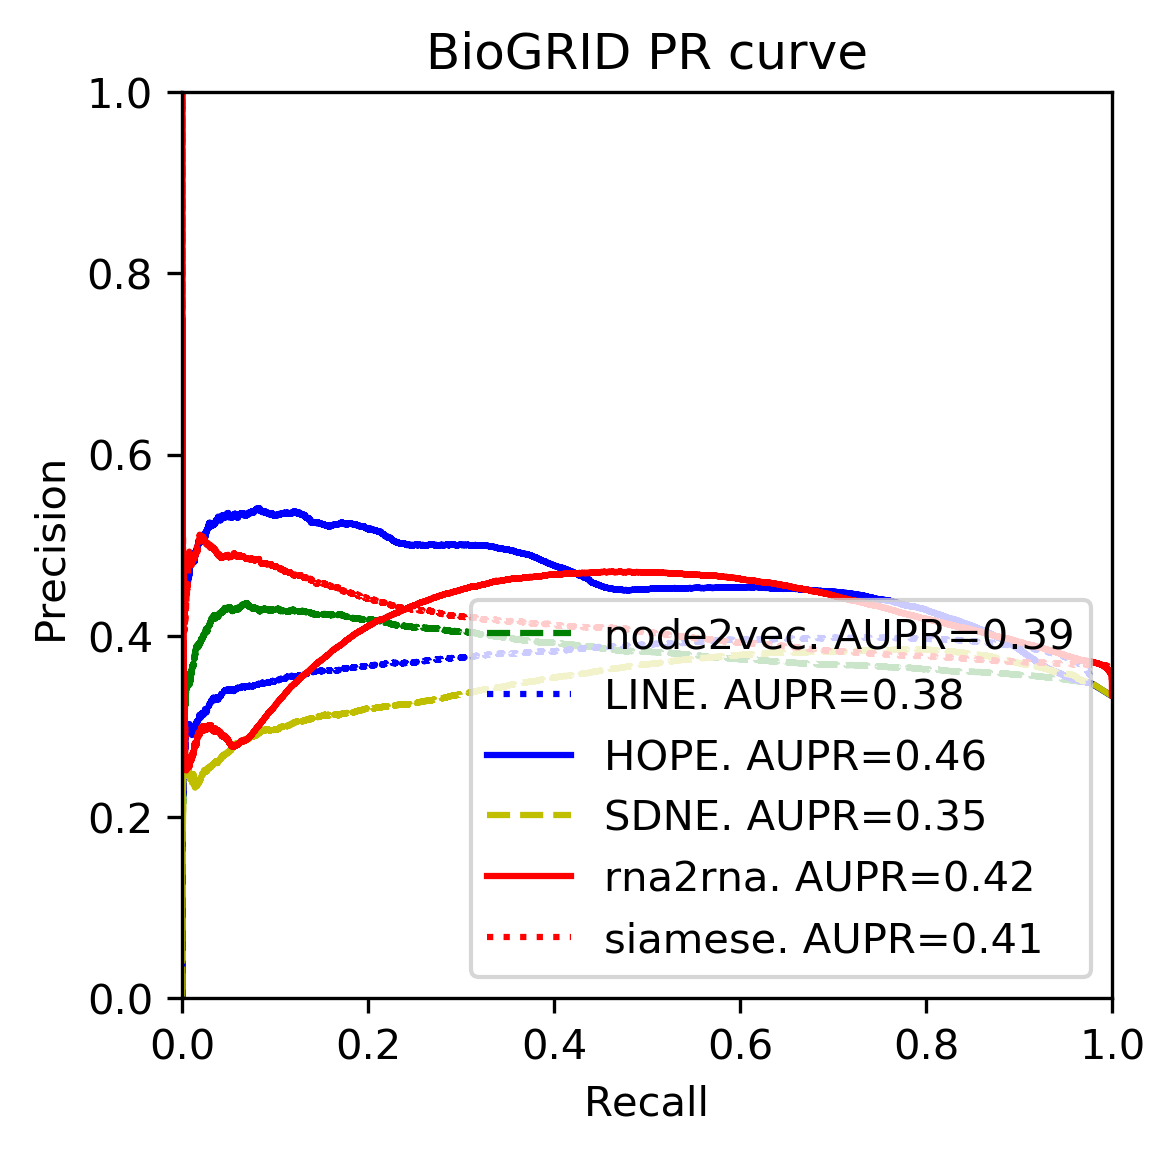

lncRInter
Ed_count: 191 , Eu_count: 0 , En_count: 0


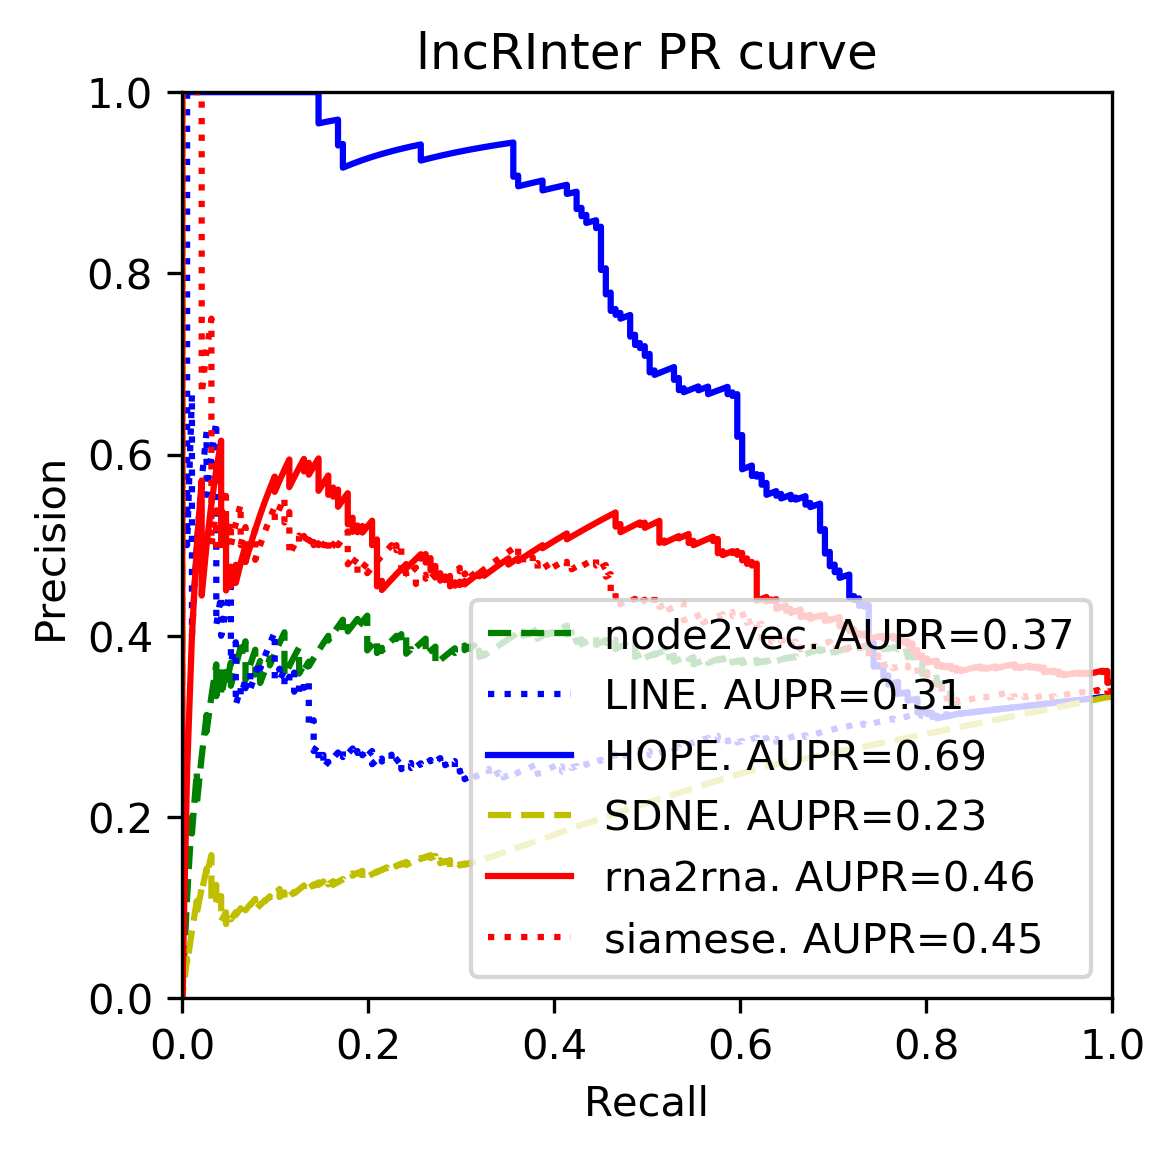

In [12]:
from moge.evaluation.link_prediction import evaluate_pr_curve_link_pred, evaluate_pr_curve_link_pred_by_database
# evaluate_pr_curve_link_pred(methods, X, y_true)
evaluate_pr_curve_link_pred_by_database(methods, generator_Ed, 
                                        databases=["lncrna2target", "miRTarBase", "BioGRID", "lncRInter"])

# Top-K Link Prediction

In [15]:
from moge.evaluation.link_prediction import evaluate_top_k_link_pred

for method in methods.keys():
    print(method)
    print(evaluate_top_k_link_pred(methods[method], network_train=network, network_test=network_val, 
                         node_list=methods[method].node_list, edge_type="d", top_k=500))

node2vec
{'precision': 0.0, 'recall': 0.0}
LINE
{'precision': 0.0, 'recall': 0.0}
HOPE
{'precision': 0.0, 'recall': 0.0}
SDNE
{'precision': 0.0, 'recall': 0.0}
rna2rna
{'precision': 0.004, 'recall': 2.2553762531434306e-05}
siamese
{'precision': 0.0, 'recall': 0.0}


In [16]:
from moge.evaluation.node_clustering import evaluate_clustering

for method in methods.keys():
    print(method)
    print(evaluate_clustering(methods[method], network=network, node_label="Family", 
                              max_clusters=500, n_clusters=None))

node2vec
Clustering 12838 nodes with n_clusters: 500
{'homogeneity': 0.473051347260587, 'completeness': 0.5275395734542537, 'nmi': 0.4988118536544877}
LINE
Clustering 12838 nodes with n_clusters: 500
{'homogeneity': 0.49547398294596573, 'completeness': 0.5364397621001928, 'nmi': 0.5151437255571777}
HOPE
Clustering 12838 nodes with n_clusters: 500
{'homogeneity': 0.3950648665014661, 'completeness': 0.5001649427946125, 'nmi': 0.44144552449440555}
SDNE
Clustering 12838 nodes with n_clusters: 500
{'homogeneity': 0.3771846239566094, 'completeness': 0.49108651351992744, 'nmi': 0.4266646072573883}
rna2rna
Clustering 14254 nodes with n_clusters: 500
{'homogeneity': 0.48006214508795336, 'completeness': 0.5365970531821613, 'nmi': 0.5067576879977465}
siamese
Clustering 14254 nodes with n_clusters: 500
{'homogeneity': 0.4883159914833564, 'completeness': 0.5195965464351803, 'nmi': 0.5034708731132583}


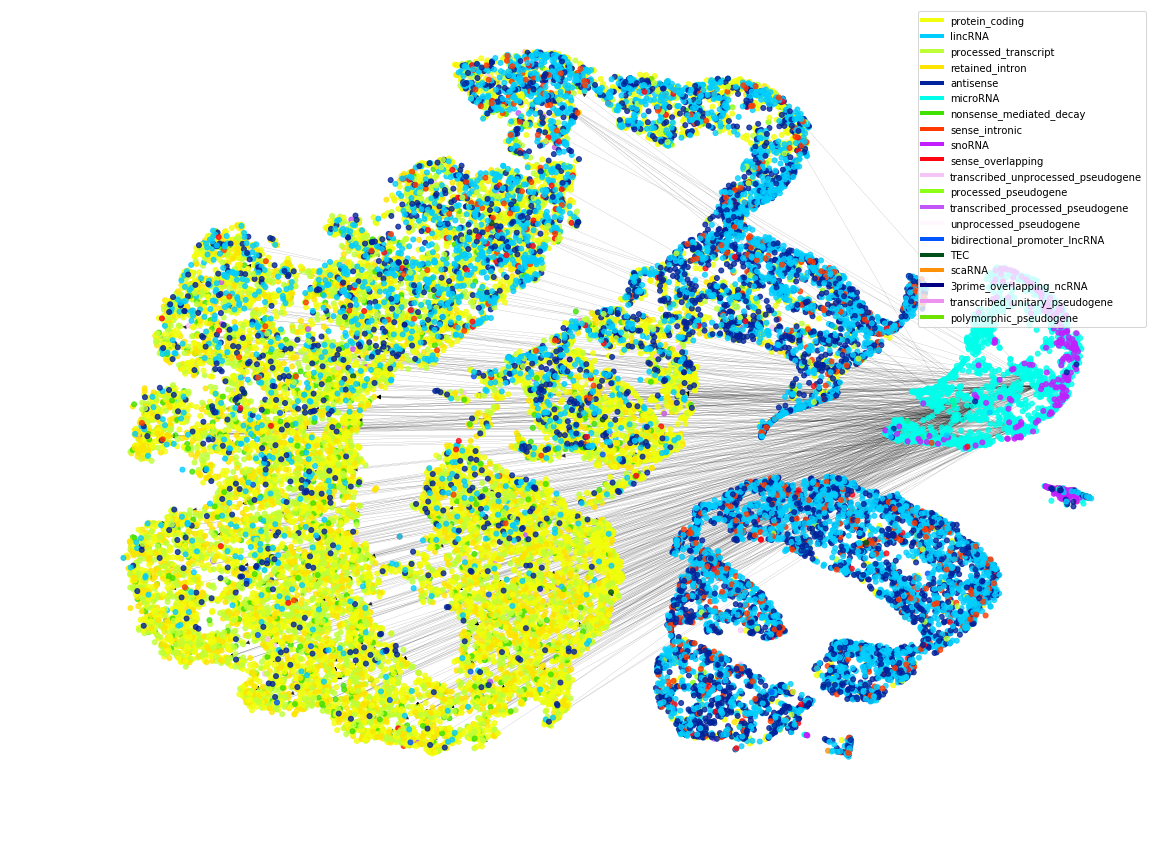

In [13]:
from moge.visualization.visualize_embedding import visualize_embedding
visualize_embedding(siamese, network=network, node_label="locus_type", 
                    edgelist=network_val.get_edgelist(node_list=network.node_list, edge_types=["d"])[:500],
#                     test_nodes=node_list,
                    cmap="gist_ncar",)

In [18]:
from moge.evaluation.node_classification import evaluate_classification

for method in methods.keys():
    print()
    print(method)
    print([(k, np.average(v)) for k,v in evaluate_classification(methods[method], network, cv=5,
                                  node_label="Disease association", multilabel=False,
                                  scoring=['precision_macro', 'recall_macro', "f1_macro"],
                                                                verbose=True).items()])


node2vec
# of labels with >cv samples: 105 , # of nodes to train/test: 1762


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[('fit_time', 1.055536413192749), ('score_time', 0.028571653366088866), ('test_precision_macro', 0.015807961860222746), ('test_recall_macro', 0.01783871074259305), ('test_f1_macro', 0.015503116146400295)]

LINE
# of labels with >cv samples: 105 , # of nodes to train/test: 1762


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[('fit_time', 1.6031650066375733), ('score_time', 0.03406424522399902), ('test_precision_macro', 0.025895864037130456), ('test_recall_macro', 0.02648393484470976), ('test_f1_macro', 0.025147635048809597)]

HOPE
# of labels with >cv samples: 105 , # of nodes to train/test: 1762


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[('fit_time', 7.5794346809387205), ('score_time', 0.023938512802124022), ('test_precision_macro', 0.020974145499020137), ('test_recall_macro', 0.029647781802382735), ('test_f1_macro', 0.021925330842377057)]

SDNE
# of labels with >cv samples: 105 , # of nodes to train/test: 1762


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[('fit_time', 7.079440069198609), ('score_time', 0.02460446357727051), ('test_precision_macro', 0.020583626093195598), ('test_recall_macro', 0.027868976716128896), ('test_f1_macro', 0.021000661563355526)]

rna2rna
# of labels with >cv samples: 105 , # of nodes to train/test: 1945
[('fit_time', 1.1606288433074952), ('score_time', 0.03199315071105957), ('test_precision_macro', 0.021497003538884712), ('test_recall_macro', 0.03327806696227749), ('test_f1_macro', 0.02234096124390922)]

siamese
# of labels with >cv samples: 105 , # of nodes to train/test: 1945
[('fit_time', 11.979203510284425), ('score_time', 0.026834964752197266), ('test_precision_macro', 0.01090594866928068), ('test_recall_macro', 0.02334567187198766), ('test_f1_macro', 0.013797064891874083)]


In [14]:
for method in methods.keys():
    print("\n", method)
    print(methods[method].get_scalefree_fit_score(methods[method].node_list))
    # for A, B in [("MIR", "LNC"), ("LNC", "MIR"), ("LNC", "GE"), ("MIR", "GE"), ("GE", "GE")]:
    #    print(A, B, methods[method].get_scalefree_fit_score(network.nodes[A], network.nodes[B]))


 node2vec


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/evaluation/utils.py:18: RuntimeWarning: divide by zero encountered in log10
  d = np.log10(cosine_adj_hist_dist.pdf(np.power(degrees, k_power)))


0.666616496227623

 LINE
0.7591531795770151

 HOPE
0.8708232175454722

 SDNE
0.5917773480837087

 rna2rna
0.2292240152151406

 siamese
0.05199428960808505


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/evaluation/utils.py:17: RuntimeWarning: divide by zero encountered in log10
  c = np.log10(np.power(degrees, k_power))
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/evaluation/utils.py:18: RuntimeWarning: divide by zero encountered in log10
  d = np.log10(cosine_adj_hist_dist.pdf(np.power(degrees, k_power)))


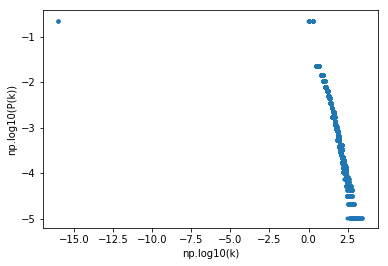

0.8423381196737936

In [25]:
from moge.evaluation.utils import get_scalefree_fit_score
adj = network.get_adjacency_matrix(edge_types=["d"], node_list=network.node_list)
network_degrees = np.sum(adj, axis=1)
get_scalefree_fit_score(network_degrees, plot=True)

# AUC Rate

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>